# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [10]:
# Importing necessary libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Ignoring warnings during execution
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# Function to read data from a file and extract text data and sentiments
def read_data(file_path):
    text_data, sentiments = [], []
    file_data = open(file_path).read()
    for i, j in enumerate(file_data.split("\n")):
        after_split = j.split(' ')
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])
    return text_data, sentiments


In [12]:
# Function to preprocess data
def preprocess_data(data_frame):
    # Convert sentiment classes to integers
    data_frame['Sentimental Value'] = pd.to_numeric(data_frame['Sentimental Value'], errors='coerce')

    # Drop rows with NaN values in the target variable
    data_frame = data_frame.dropna(subset=['Sentimental Value'])

    # Pre-processing
    # Removal of special characters
    data_frame['After noise removal'] = data_frame['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

    # Removal of punctuation
    data_frame['Punctuation removal'] = data_frame['After noise removal'].str.replace('[^\w\s]', '')

    # Stopwords removal
    stop_word = stopwords.words('english')
    data_frame['Stopwords removal'] = data_frame['Punctuation removal'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_word))

    # Lowercasing
    data_frame['Lower casing'] = data_frame['Stopwords removal'].apply(lambda x: " ".join(word.lower() for word in x.split()))

    return data_frame


In [13]:
# Function to vectorize data using TF-IDF
def vectorize_data(train_df, test_df):
    # TF-IDF Vectorization
    tfidf_vector = TfidfVectorizer(analyzer='word')
    tfidf_vector.fit(train_df['Lower casing'])
    x_train = tfidf_vector.transform(train_df['Lower casing'])
    tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary=tfidf_vector.vocabulary_)
    tfidf_vector_test.fit(test_df['Lower casing'])
    x_test = tfidf_vector_test.transform(test_df['Lower casing'])

    return x_train, x_test


In [14]:
# Function to evaluate classifier performance
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    accuracy = accuracy_score(predicted, y_test)
    print(f"Accuracy of Training data ({classifier.__class__.__name__}): {accuracy}")

    predicted_testing = classifier.predict(x_test)
    accuracy_testing = accuracy_score(predicted_testing, y_test)
    print(f"Accuracy of Testing data ({classifier.__class__.__name__}): {accuracy_testing}")

    if 'XGB' not in str(classifier):
        scoring = 'accuracy'
        kfold = KFold(10, random_state=7, shuffle=True)
        cross_val = cross_val_score(classifier, x_test, y_test, cv=kfold, scoring=scoring).mean()
        print(f"Cross-validation score ({classifier.__class__.__name__}): {cross_val}")

    print(f"\nClassification Report ({classifier.__class__.__name__}):\n")
    print(classification_report(y_test, predicted))


In [15]:
# Reading data from files
training_text_data, training_sentiments = read_data('stsa-train.txt')
testing_text_data, testing_sentiments = read_data('stsa-test.txt')

# Creating data frames for training and testing data
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)), columns=['Sentimental Value', 'Raw Data'])
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)), columns=['Sentimental Value', 'Raw Data'])

# Pre-processing data
training_df = preprocess_data(training_df)
testing_df = preprocess_data(testing_df)

# Vectorizing data
x_train, x_test = vectorize_data(training_df, testing_df)


In [16]:
# Splitting data for training and testing
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, training_df['Sentimental Value'],
                                                                      test_size=0.2, random_state=42)

In [17]:
# Ensuring target variables are integers
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

# List of classifiers to evaluate
classifiers = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

In [18]:
# Evaluating each classifier
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__}:")
    evaluate_classifier(classifier, x_train, y_train, x_valid, y_valid)

Evaluating MultinomialNB:
Accuracy of Training data (MultinomialNB): 0.7911849710982659
Accuracy of Testing data (MultinomialNB): 0.7911849710982659
Cross-validation score (MultinomialNB): 0.7015848191012408

Classification Report (MultinomialNB):

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       671
           1       0.75      0.89      0.81       713

    accuracy                           0.79      1384
   macro avg       0.80      0.79      0.79      1384
weighted avg       0.80      0.79      0.79      1384

Evaluating SVC:
Accuracy of Training data (SVC): 0.796242774566474
Accuracy of Testing data (SVC): 0.796242774566474
Cross-validation score (SVC): 0.7008758210822645

Classification Report (SVC):

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       671
           1       0.77      0.86      0.81       713

    accuracy                           0.80      1384
   macro 

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [2]:
import pandas as pd

data = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')

data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:
#K-Means clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# For clustering, we can use the 'Reviews' column. Let's first vectorize the text data.
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Reviews'].dropna())

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

# Getting the cluster labels
cluster_labels = kmeans.labels_

data['KMeans_Cluster'] = np.nan
data.loc[data['Reviews'].notna(), 'KMeans_Cluster'] = cluster_labels

data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,KMeans_Cluster
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,1.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,4.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,1.0


In [4]:
#DBSCAN
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

# Vectorizing the reviews using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Reviews'].dropna())

# Selecting a random sample from the dataset
sample_size = 1000  # Adjust the sample size based on your needs and resources
sampled_data = data.sample(n=sample_size, random_state=0)

# Vectorizing the sampled reviews
sampled_X = vectorizer.transform(sampled_data['Reviews'].dropna())

dbscan_sampled = DBSCAN(eps=0.5, min_samples=5)
dbscan_sampled.fit(sampled_X)

#Sample labels
dbscan_sampled_labels = dbscan_sampled.labels_

# Add the DBSCAN cluster labels to the sampled dataframe
sampled_data['DBSCAN_Cluster_Sampled'] = dbscan_sampled_labels

print(sampled_data.head())

                                             Product Name Brand Name    Price  \
134801  BLU Studio 5.0 C HD - Unlocked Cell Phones - R...        BLU  2000.00   
123493                         Blu LIFE 8 Unlocked (Pink)        BLU   199.98   
335592  Samsung Galaxy S Duos II S7582 DUAL SIM Factor...    Samsung   299.99   
246353  Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...   Motorola    82.00   
347432  Samsung Galaxy S4 White i9500 16GB Factory Unl...        NaN   293.99   

        Rating                                            Reviews  \
134801       5  For the price I paid for this devices, its fan...   
123493       5  love love love it....good buy...recommend to a...   
335592       4                                               Good   
246353       1  Not good. Returned first phone and they sent m...   
347432       2  I have purchased this product about 3 months a...   

        Review Votes  KMeans_Cluster  DBSCAN_Cluster_Sampled  
134801           0.0             1.

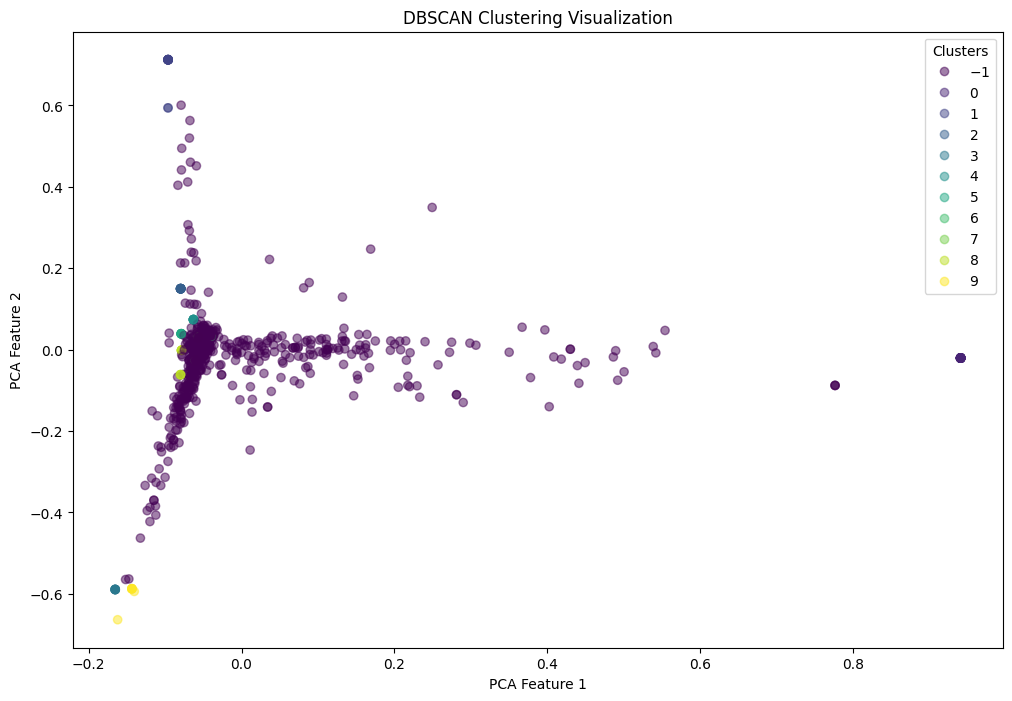

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Applying PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
sampled_X_reduced = pca.fit_transform(sampled_X.toarray())

# Extracting the PCA reduced coordinates
x_coords = sampled_X_reduced[:, 0]
y_coords = sampled_X_reduced[:, 1]

# Plotting the DBSCAN clustering results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_coords, y_coords, c=dbscan_sampled_labels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering Visualization')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [6]:
#Hierarchial clustering
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering

# Vectorizing the reviews using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Reviews'].dropna())

# Selecting a smaller subset of the data for clustering
sample_size = 500  # Adjust as needed
sampled_data = data.sample(n=sample_size, random_state=0)
sampled_X = vectorizer.transform(sampled_data['Reviews'].dropna())

# Reducing the dimensionality of the subset with Truncated SVD
svd = TruncatedSVD(n_components=50, random_state=0)
sampled_X_reduced = svd.fit_transform(sampled_X)

# Applying Agglomerative Clustering to the reduced data
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_cluster_labels = agg_clustering.fit_predict(sampled_X_reduced)

# Attaching the cluster labels to the subset
sampled_data['Agglomerative_Cluster'] = agg_cluster_labels

# Display the first few rows with the cluster labels
print(sampled_data.head())

                                             Product Name Brand Name    Price  \
134801  BLU Studio 5.0 C HD - Unlocked Cell Phones - R...        BLU  2000.00   
123493                         Blu LIFE 8 Unlocked (Pink)        BLU   199.98   
335592  Samsung Galaxy S Duos II S7582 DUAL SIM Factor...    Samsung   299.99   
246353  Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...   Motorola    82.00   
347432  Samsung Galaxy S4 White i9500 16GB Factory Unl...        NaN   293.99   

        Rating                                            Reviews  \
134801       5  For the price I paid for this devices, its fan...   
123493       5  love love love it....good buy...recommend to a...   
335592       4                                               Good   
246353       1  Not good. Returned first phone and they sent m...   
347432       2  I have purchased this product about 3 months a...   

        Review Votes  KMeans_Cluster  Agglomerative_Cluster  
134801           0.0             1.0

In [7]:
#WordVec
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Ensure you have the 'punkt' tokenizer downloaded
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# Preprocessing text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into words
    words = word_tokenize(text)
    return words

# Apply preprocessing to each review
processed_reviews = data['Reviews'].dropna().apply(preprocess_text)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=processed_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Retrieve the word vectors from the trained Word2Vec model
word_vectors = word2vec_model.wv

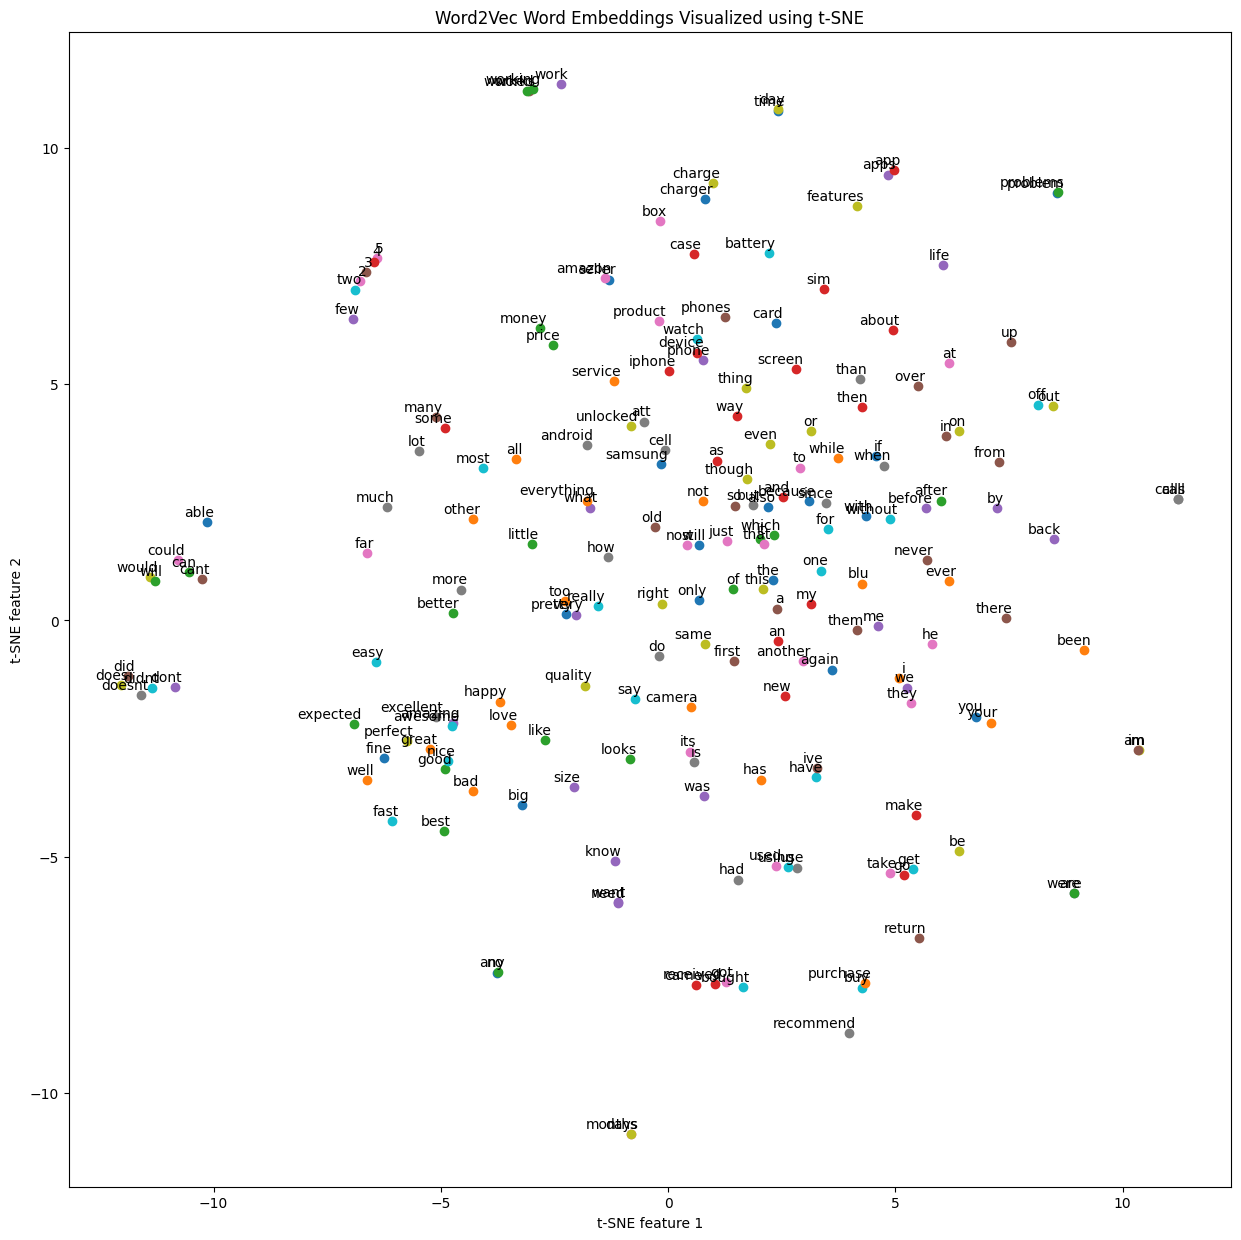

In [9]:
# Select a subset of words to visualize (for example, the first 200 words)
selected_words = list(word_vectors.index_to_key)[:200]
selected_vectors = [word_vectors[word] for word in selected_words]

# Convert the list of vectors to a NumPy array
selected_vectors_array = np.array(selected_vectors)

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(selected_vectors_array)

# Plotting the 2D vectors with labels
plt.figure(figsize=(15, 15))
for i, word in enumerate(selected_words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title('Word2Vec Word Embeddings Visualized using t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

K-means clustering is based on the distance between data points and clustering centroids

DBScan also known as Density based clustering runs on the regions with the largest concentration of points and are detected and distinguished from empty space.
As the name indicates, hierarchical clustering includes layer-by-layer clustering.

K-means, DBSCAN, and hierarchical clustering are all data grouping algorithms, each with their own set of strengths and disadvantages. Word2Vec and BERT, on the other hand, transform words/sentences into computer-understandable numbers, hence improving language understanding and job completion.





# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [10]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
This inclass exercise is very good learning experience. I used the clustering algorithms during my internship in INDIA .Mainly, DBScan algorithm is not used frequently.
Adding to that, this course gave me great chance to learn about the LLMs .

'''

'\nThis inclass exercise is very good learning experience. I used the clustering algorithms during my internship in INDIA .Mainly, DBScan algorithm is not used frequently.\nAdding to that, this course gave me great chance to learn about the LLMs .\n\n'